In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("default")
sns.set(style="whitegrid")

PATH = "/Users/rodrigokauer/Desktop/tcc/dataset/footystats"
PATTERN = "brazil-serie-a-matches-*-stats.csv"


MAIN_VARS = [
    "home_team_goal_count", "away_team_goal_count",
    "home_team_shots", "away_team_shots",
    "home_team_shots_on_target", "away_team_shots_on_target",
    "home_team_corner_count", "away_team_corner_count",
    "home_team_yellow_cards", "away_team_yellow_cards",
    "home_team_red_cards", "away_team_red_cards",
    "home_team_fouls", "away_team_fouls",
    "home_team_possession", "away_team_possession",
    "home_ppg", "away_ppg", "Pre-Match PPG (Home)", "Pre-Match PPG (Away)"
]

In [3]:
DATE_COL = "date_GMT"

print("Carregando arquivos FootyStats...")
pattern_path = os.path.join(PATH, PATTERN)
files = sorted(glob.glob(pattern_path))

print(f"Arquivos encontrados: {len(files)}")
if len(files) == 0:
    raise FileNotFoundError(
        f"Nenhum arquivo encontrado em:\n{pattern_path}\n"
        "Verifique PATH e o nome/padrão dos arquivos."
    )

dfs = {}  

for file in files:
    
    base = os.path.basename(file)
    parts = base.split("-")
    
    
    season = parts[-3] if len(parts) >= 3 else base

    df_temp = pd.read_csv(file)
    dfs[season] = df_temp
    print(f"Temporada {season} carregada → shape: {df_temp.shape}")


first_season = next(iter(dfs))
print(f"\nExemplo de colunas (temporada {first_season}):")
print(dfs[first_season].columns.tolist())

print("\nTipos (temporada exemplo):")
print(dfs[first_season].dtypes.value_counts())

Carregando arquivos FootyStats...
Arquivos encontrados: 12
Temporada to carregada → shape: (380, 66)
Temporada to carregada → shape: (380, 66)
Temporada to carregada → shape: (380, 66)
Temporada to carregada → shape: (380, 66)
Temporada to carregada → shape: (380, 66)
Temporada to carregada → shape: (380, 66)
Temporada to carregada → shape: (380, 66)
Temporada to carregada → shape: (380, 66)
Temporada to carregada → shape: (380, 66)
Temporada to carregada → shape: (380, 66)
Temporada to carregada → shape: (380, 66)
Temporada to carregada → shape: (380, 66)

Exemplo de colunas (temporada to):
['timestamp', 'date_GMT', 'status', 'attendance', 'home_team_name', 'away_team_name', 'referee', 'Game Week', 'Pre-Match PPG (Home)', 'Pre-Match PPG (Away)', 'home_ppg', 'away_ppg', 'home_team_goal_count', 'away_team_goal_count', 'total_goal_count', 'total_goals_at_half_time', 'home_team_goal_count_half_time', 'away_team_goal_count_half_time', 'home_team_goal_timings', 'away_team_goal_timings', 'ho

In [4]:
def safe_to_numeric(s: pd.Series) -> pd.Series:
    """Converte string percentuais etc. para numérico, sem quebrar."""
    if s.dtype == object:
        s = s.astype(str).str.replace("%", "", regex=False)
    return pd.to_numeric(s, errors="coerce")

def season_summary(df_season: pd.DataFrame, season: str) -> pd.DataFrame:
    """Retorna tabela com mean/median/std/min/max/missing% para colunas numéricas."""
    cols = [c for c in MAIN_VARS if c in df_season.columns]
    tmp = df_season.copy()


    for c in cols:
        tmp[c] = safe_to_numeric(tmp[c])

    num = tmp[cols]
    desc = num.describe().T
    desc.rename(columns={"50%": "median"}, inplace=True)
    desc["missing_%"] = num.isna().mean() * 100
    desc["season"] = season


    out = desc[["season", "mean", "median", "std", "min", "max", "missing_%"]].round(3)
    return out.reset_index().rename(columns={"index": "coluna"})

In [5]:
def plot_hist_box(df_season: pd.DataFrame, season: str, col: str):
    """Histograma + boxplot para uma coluna."""
    if col not in df_season.columns:
        return

    s = safe_to_numeric(df_season[col])

    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    sns.histplot(s.dropna(), bins=30, kde=True, ax=ax[0])
    ax[0].set_title(f"{season} — Distribuição: {col}")

    sns.boxplot(x=s, ax=ax[1])
    ax[1].set_title(f"{season} — Boxplot: {col}")

    plt.tight_layout()
    plt.show()

def plot_box_many(df_season: pd.DataFrame, season: str, cols: list):
    """Boxplot horizontal com várias variáveis."""
    cols = [c for c in cols if c in df_season.columns]
    if not cols:
        return

    tmp = df_season[cols].copy()
    for c in cols:
        tmp[c] = safe_to_numeric(tmp[c])

    plt.figure(figsize=(14, max(4, 0.35 * len(cols))))
    sns.boxplot(data=tmp, orient="h")
    plt.title(f"{season} — Boxplot (variáveis selecionadas)")
    plt.tight_layout()
    plt.show()

In [6]:
def plot_corr(df_season: pd.DataFrame, season: str, cols: list):
    """Heatmap de correlação (apenas colunas numéricas selecionadas)."""
    cols = [c for c in cols if c in df_season.columns]
    if not cols:
        return

    tmp = df_season[cols].copy()
    for c in cols:
        tmp[c] = safe_to_numeric(tmp[c])

    corr = tmp.corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0, linewidths=0.3)
    plt.title(f"{season} — Correlação (variáveis selecionadas)")
    plt.tight_layout()
    plt.show()


EDA — Temporada to

Top 12 linhas da tabela de estatísticas (mean/median/std/min/max/missing%):


/var/folders/s6/4g4mk68x1679121_jq2y5hwh0000gn/T/ipykernel_87693/387619422.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_season[DATE_COL] = pd.to_datetime(df_season[DATE_COL], errors="coerce")


,coluna,season,mean,median,std,min,max,missing_%
0,home_team_goal_count,to,1.411,1.0,1.085,0.0,5.0,0.0
1,away_team_goal_count,to,1.034,1.0,0.986,0.0,6.0,0.0
2,home_team_shots,to,11.203,11.0,3.772,2.0,25.0,0.0
3,away_team_shots,to,8.876,9.0,3.520,1.0,22.0,0.0
4,home_team_shots_on_target,to,5.103,5.0,2.373,0.0,14.0,0.0
5,away_team_shots_on_target,to,4.055,4.0,2.302,0.0,18.0,0.0
6,home_team_corner_count,to,5.682,5.0,2.742,0.0,14.0,0.0
7,away_team_corner_count,to,4.489,4.0,2.574,0.0,12.0,0.0
8,home_team_yellow_cards,to,2.447,2.0,1.510,0.0,8.0,0.0
9,away_team_yellow_cards,to,2.692,3.0,1.542,0.0,9.0,0.0



Top 10 colunas com missing (%):


attendance                91.578947
referee                   39.473684
stadium_name              34.210526
away_team_goal_timings    32.894737
home_team_goal_timings    20.789474
away_team_possession       0.000000
home_team_possession       0.000000
Home Team Pre-Match xG     0.000000
Away Team Pre-Match xG     0.000000
away_team_fouls            0.000000
dtype: float64

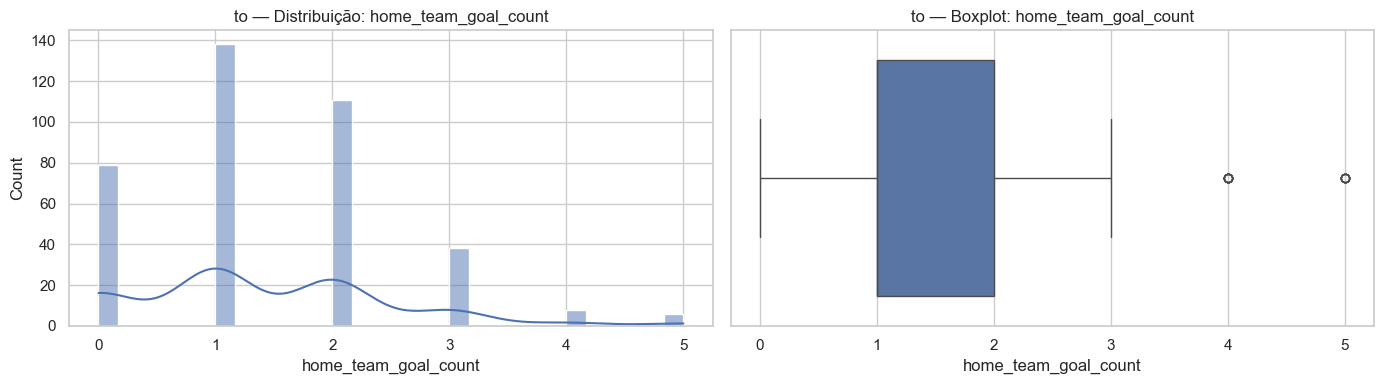

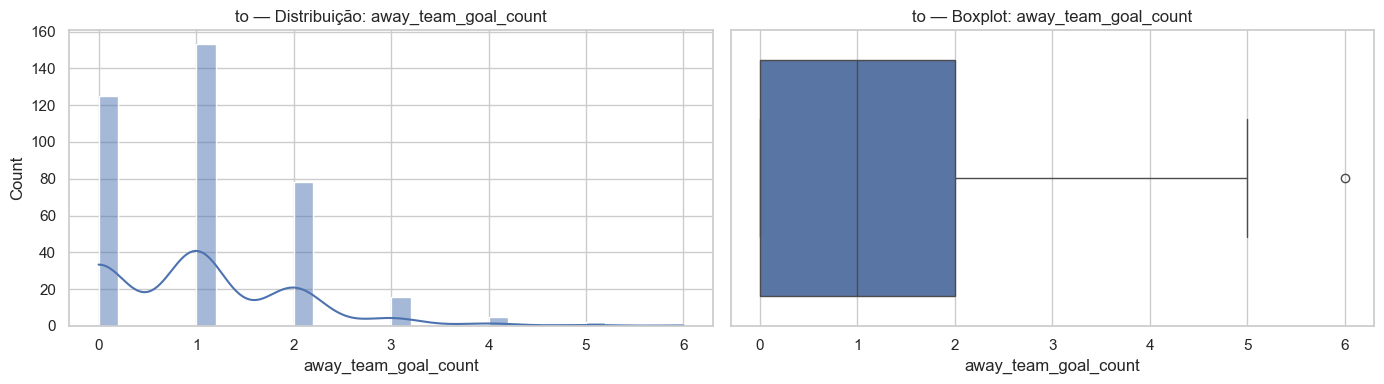

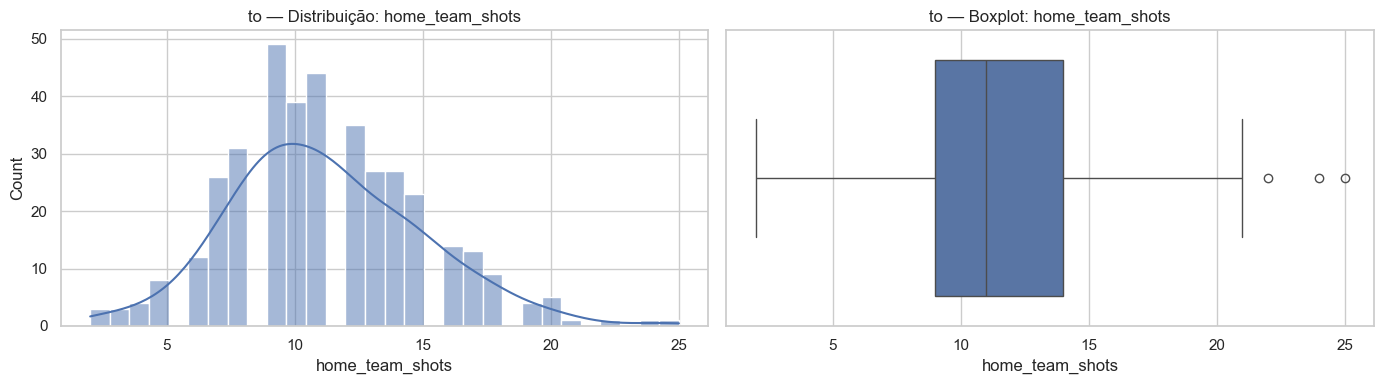

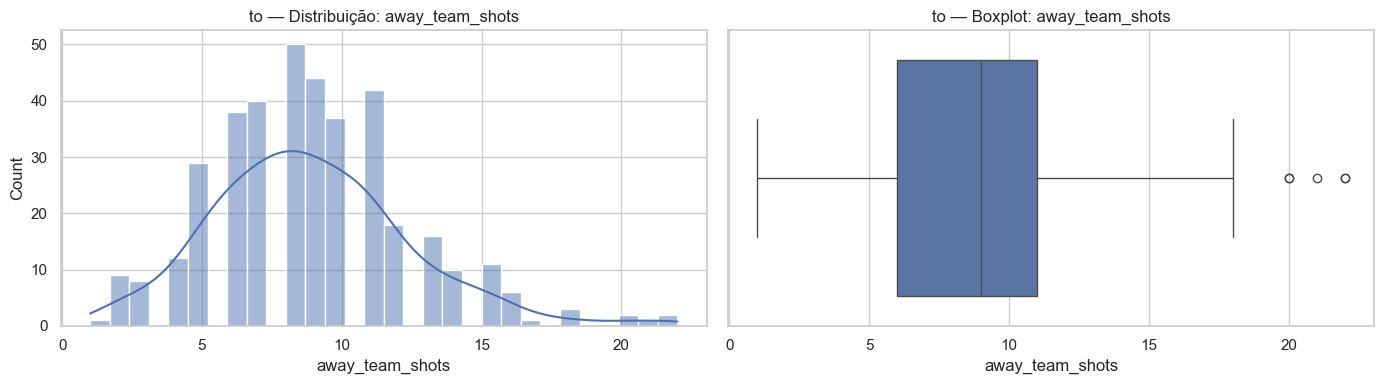

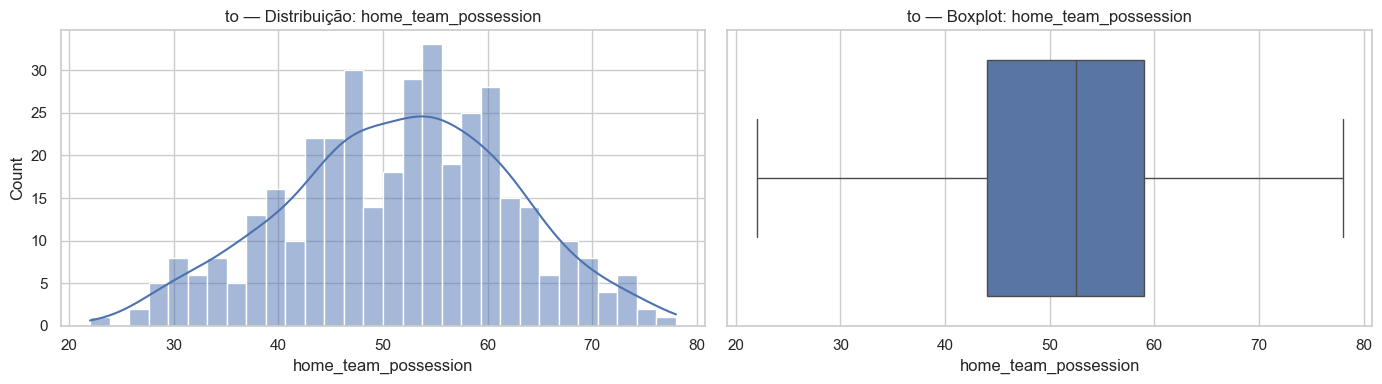

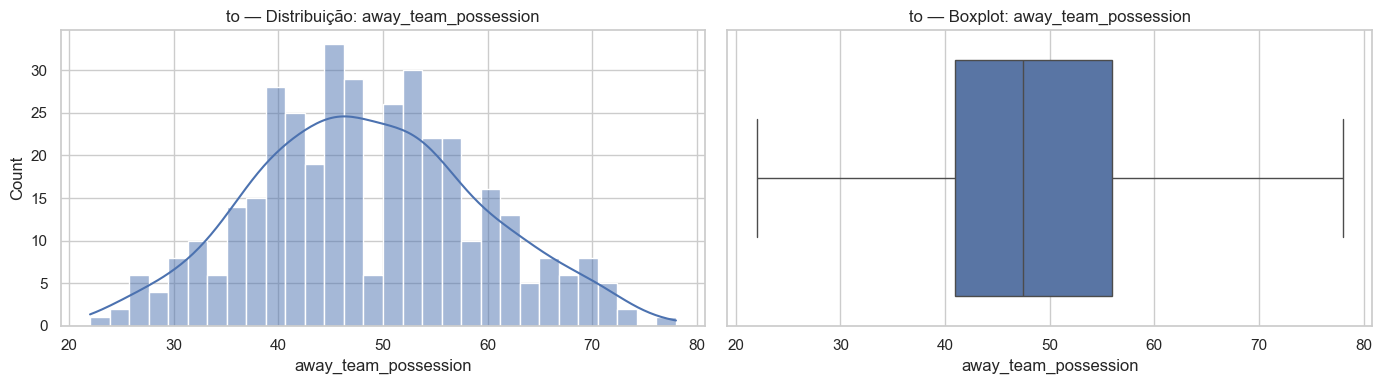

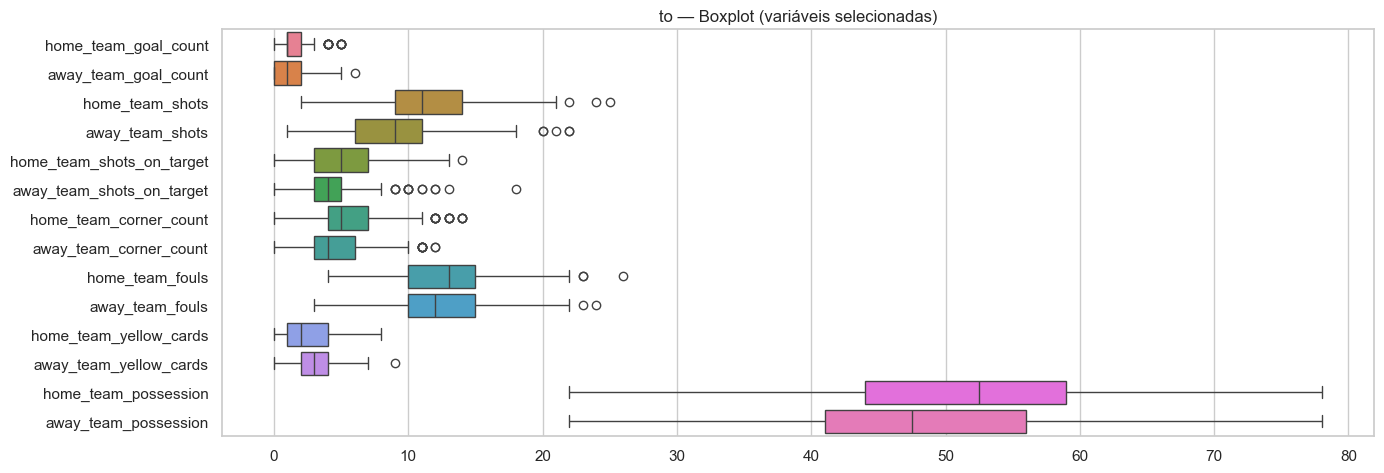

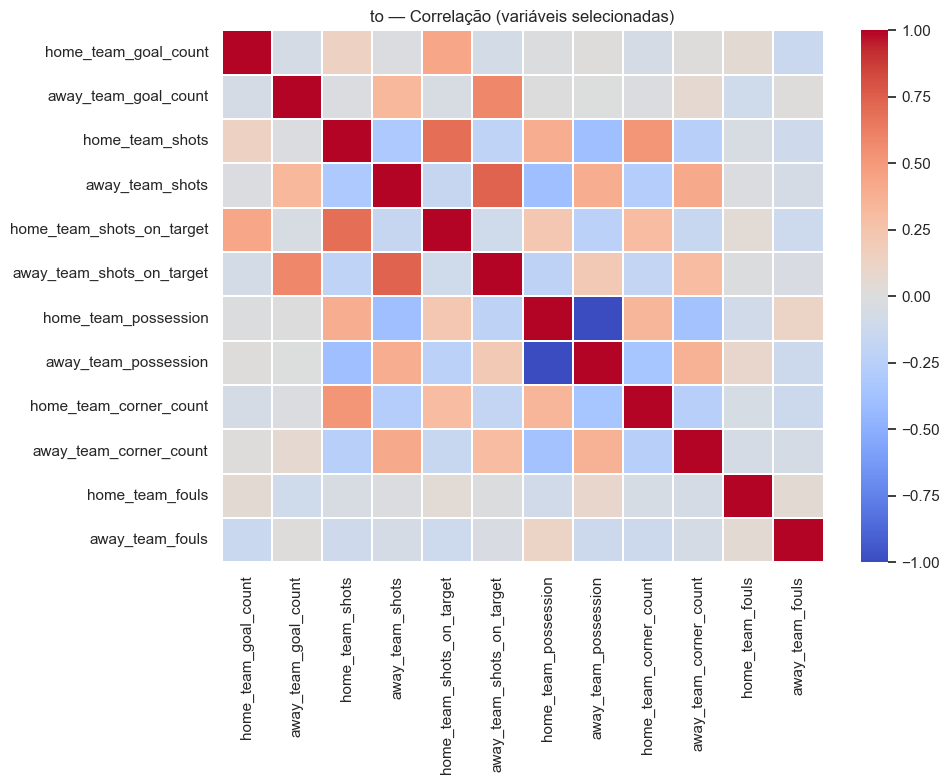


EDA — Visão global (em memória)

Tabela global (ALL) — estatísticas descritivas:


,coluna,season,mean,median,std,min,max,missing_%
0,home_team_goal_count,ALL,1.411,1.000,1.085,0.00,5.00,0.0
1,away_team_goal_count,ALL,1.034,1.000,0.986,0.00,6.00,0.0
2,home_team_shots,ALL,11.203,11.000,3.772,2.00,25.00,0.0
3,away_team_shots,ALL,8.876,9.000,3.520,1.00,22.00,0.0
4,home_team_shots_on_target,ALL,5.103,5.000,2.373,0.00,14.00,0.0
5,away_team_shots_on_target,ALL,4.055,4.000,2.302,0.00,18.00,0.0
6,home_team_corner_count,ALL,5.682,5.000,2.742,0.00,14.00,0.0
7,away_team_corner_count,ALL,4.489,4.000,2.574,0.00,12.00,0.0
8,home_team_yellow_cards,ALL,2.447,2.000,1.510,0.00,8.00,0.0
9,away_team_yellow_cards,ALL,2.692,3.000,1.542,0.00,9.00,0.0



Resumo EDA por temporada salvo em: /Users/rodrigokauer/Desktop/tcc/dataset/footystats/eda_summary_por_temporada.csv


In [ ]:
all_summaries = []

for season, df_season in dfs.items():
    print(f"Temporada {season}")

    # datas 
    if DATE_COL in df_season.columns:
        df_season[DATE_COL] = pd.to_datetime(df_season[DATE_COL], errors="coerce")

    # resumo estatístico
    summ = season_summary(df_season, season)
    all_summaries.append(summ)

    print("\nTop 12 linhas da tabela de estatísticas (mean/median/std/min/max/missing%):")
    display(summ.head(12))

    # missing gerais (top colunas)
    miss = df_season.isna().mean().sort_values(ascending=False) * 100
    print("\nTop 10 colunas com missing (%):")
    display(miss.head(10))

    # plots principais (um por vez para não explodir gráficos)
    for col in [
        "home_team_goal_count",
        "away_team_goal_count",
        "home_team_shots",
        "away_team_shots",
        "home_team_possession",
        "away_team_possession",
    ]:
        plot_hist_box(df_season, season, col)

    # boxplot com um conjunto maior
    box_cols = [
        "home_team_goal_count", "away_team_goal_count",
        "home_team_shots", "away_team_shots",
        "home_team_shots_on_target", "away_team_shots_on_target",
        "home_team_corner_count", "away_team_corner_count",
        "home_team_fouls", "away_team_fouls",
        "home_team_yellow_cards", "away_team_yellow_cards",
        "home_team_possession", "away_team_possession",
    ]
    plot_box_many(df_season, season, box_cols)

    # correlação (principais)
    corr_cols = [
        "home_team_goal_count", "away_team_goal_count",
        "home_team_shots", "away_team_shots",
        "home_team_shots_on_target", "away_team_shots_on_target",
        "home_team_possession", "away_team_possession",
        "home_team_corner_count", "away_team_corner_count",
        "home_team_fouls", "away_team_fouls",
    ]
    plot_corr(df_season, season, corr_cols)



df_all = pd.concat(dfs.values(), ignore_index=True)


if DATE_COL in df_all.columns:
    df_all[DATE_COL] = pd.to_datetime(df_all[DATE_COL], errors="coerce")


global_summary = season_summary(df_all, "ALL")
print("\nTabela global — estatísticas descritivas:")
display(global_summary)


eda_summary_df = pd.concat(all_summaries, ignore_index=True)
out_path = os.path.join(PATH, "eda_summary_por_temporada.csv")
eda_summary_df.to_csv(out_path, index=False)
print(f"\nResumo EDA por temporada salvo em: {out_path}")
